<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Box Plots**


Estimated time needed: **45** minutes


In this lab, you will focus on the visualization of data. The dataset will be provided through an RDBMS, and you will need to use SQL queries to extract the required data.


## Objectives


In this lab you will perform the following:


-   Visualize the distribution of data.

-   Visualize the relationship between two features.

-   Visualize data composition and comparisons using box plots.


### Setup: Connecting to the Database


#### 1. Download the Database File


#### 2. Connect to the Database


**Install the needed libraries**


In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2
import matplotlib.ticker as mticker
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import requests
from tqdm.notebook import tqdm
from urllib.parse import urlparse
import sqlite3

# Set pandas option to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Connect to the SQLite database
conn = sqlite3.connect('survey-results-public.sqlite')

## Demo: Basic SQL Queries


#### Demo 1: Count the Number of Rows in the Table


In [3]:
QUERY = "SELECT COUNT(*) FROM main"
df = pd.read_sql_query(QUERY, conn)
print(df)

   COUNT(*)
0     65437


#### Demo 2: List All Tables


In [4]:
QUERY = """
SELECT name as Table_Name 
FROM sqlite_master 
WHERE type = 'table'
"""
pd.read_sql_query(QUERY, conn)

,Table_Name
0,main


#### Demo 3: Group Data by Age


In [5]:
QUERY = """
SELECT Age, COUNT(*) as count 
FROM main 
GROUP BY Age 
ORDER BY Age
"""
df_age = pd.read_sql_query(QUERY, conn)
print(df_age)

                  Age  count
0     18-24 years old  14098
1     25-34 years old  23911
2     35-44 years old  14942
3     45-54 years old   6249
4     55-64 years old   2575
5   65 years or older    772
6   Prefer not to say    322
7  Under 18 years old   2568


## Visualizing Data


### Task 1: Visualizing the Distribution of Data


**1. Box Plot of `CompTotal` (Total Compensation)**


Use a box plot to analyze the distribution and outliers in total compensation.


In [6]:
query = """
SELECT CompTotal FROM main
"""

comp_total = pd.read_sql(con=conn, sql=query)

quantile_90 = comp_total["CompTotal"].quantile(0.90)
# Limiting to 90th percentile since data being squashed into 1 bin near the left
compTotal_bot_90 = comp_total[comp_total["CompTotal"] <= quantile_90]

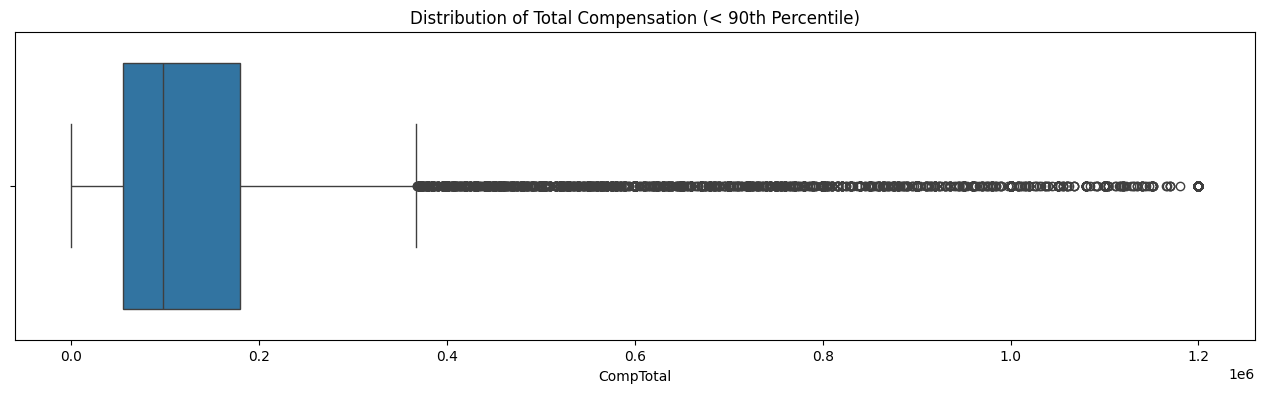

In [7]:
plt.figure(figsize=(16,4))
sns.boxplot(data=compTotal_bot_90, x="CompTotal")
plt.title("Distribution of Total Compensation (< 90th Percentile)")
plt.xlabel("CompTotal")
plt.savefig("Lab 18 Plots/Step 1-1 CompTotal Bottom 90%")

**2. Box Plot of Age (converted to numeric values)**


Convert the `Age` column into numerical values and visualize the distribution.


In [8]:
query = """
SELECT Age FROM main
"""

age = pd.read_sql(sql=query, con=conn).sort_values(by="Age")

# Extract Age Groups
age_groups = list(age["Age"].unique())
age_groups = [age_groups[-1]] + age_groups[:-1]

age_map = {
    'Under 18 years old':'17',
    '18-24 years old':'21',
    '25-34 years old':'29.5',
    '35-44 years old':'39.5',
    '45-54 years old':'49.5',
    '55-64 years old':'59.5',
    '65 years or older':'65',
}
age["Age"] = age["Age"].replace(age_map)
age["Age"] = pd.to_numeric(age["Age"], errors='coerce')


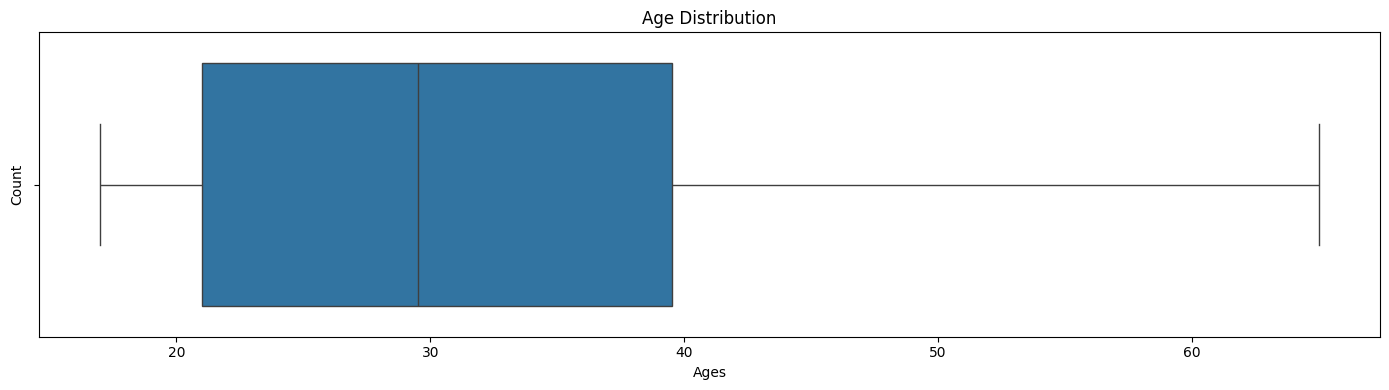

In [9]:
plt.figure(figsize=(14,4))
sns.boxplot(data=age, x="Age")

plt.title("Age Distribution")
plt.ylabel("Count")
plt.xlabel("Ages")
plt.savefig("Lab 18 Plots/Step 1-2 Age Distribution")

# Tidy up spacing so titles/labels don't overlap
plt.tight_layout()
plt.show()

### Task 2: Visualizing Relationships in Data


**1. Box Plot of `CompTotal` Grouped by Age Groups:**


Visualize the distribution of compensation across different age groups.


In [10]:
query = """
SELECT CompTotal, Age FROM main
"""

comp_age = pd.read_sql(sql=query, con=conn).sort_values(by="Age")
comp_age = comp_age.dropna(subset=["CompTotal"])

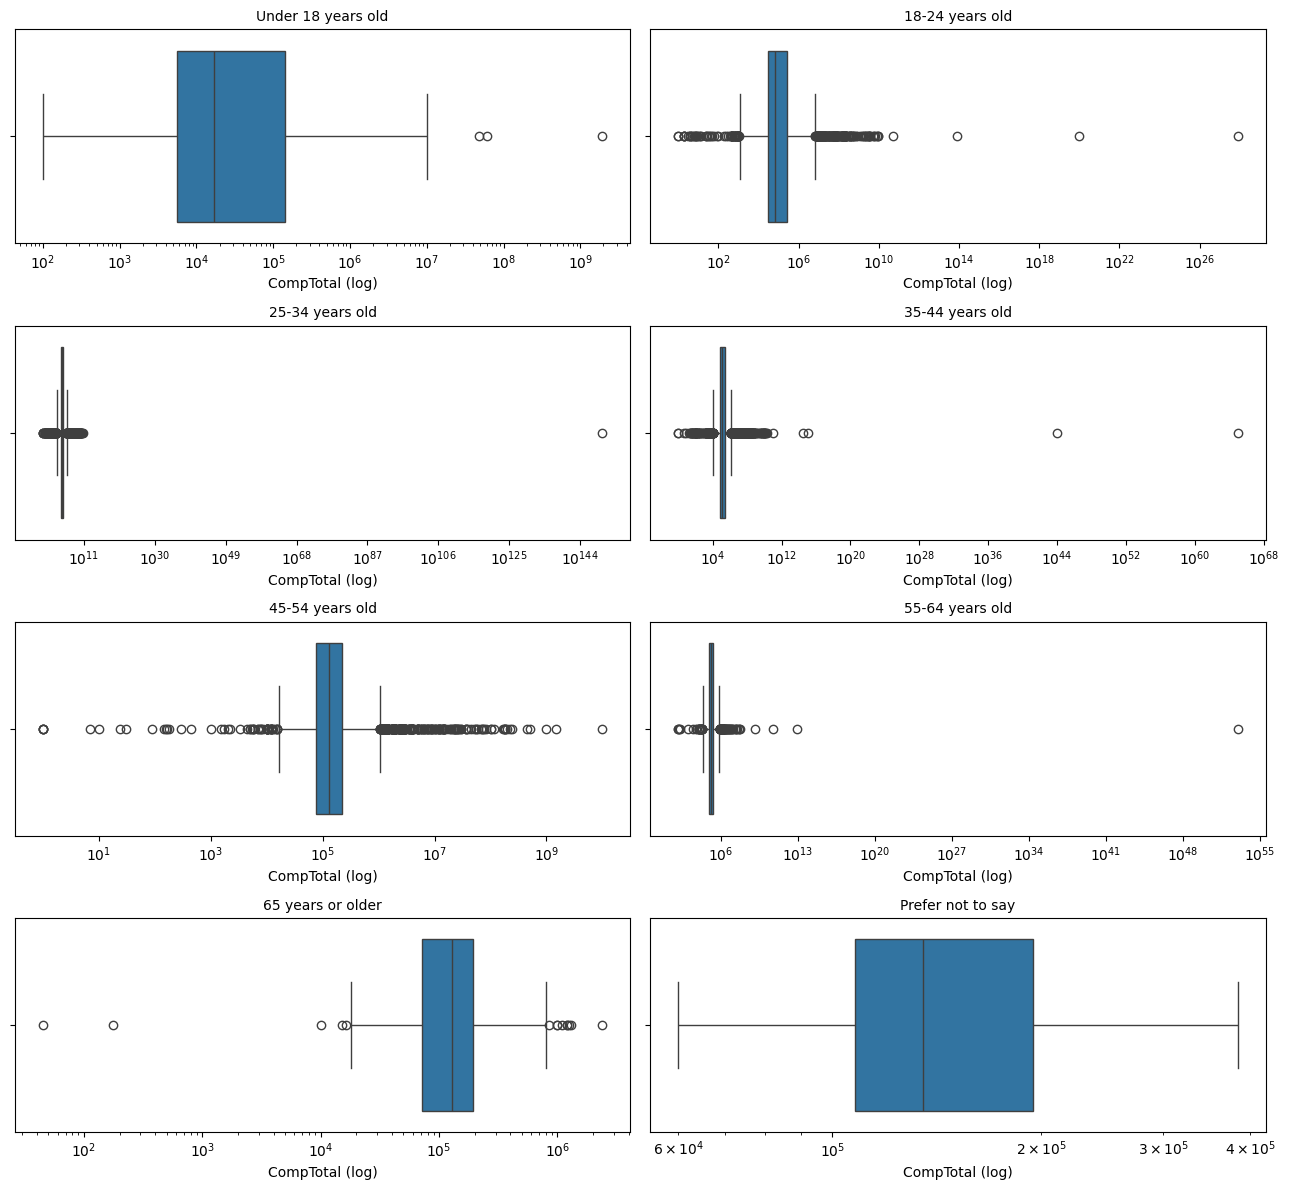

In [11]:
# Extract Age Groups
age_groups = list(comp_age["Age"].unique())
age_groups = [age_groups[-1]] + age_groups[:-1]

# plt.figure(figsize=(18,30))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 12))
axes = axes.flatten()

for i, age in enumerate(age_groups):
    age_group = comp_age.loc[comp_age["Age"] == age, "CompTotal"]
    sns.boxplot(x=age_group, ax=axes[i], log_scale=True)

    axes[i].set_title(age, fontsize=10)
    axes[i].set_xlabel("CompTotal (log)")
    axes[i].set_ylabel("")

# Tidy up spacing so titles/labels don't overlap
plt.tight_layout()
plt.savefig("Lab 18 Plots/Step 2-1 CompTotal by Age Group")
plt.show()

**2. Box Plot of `CompTotal` Grouped by Job Satisfaction (`JobSatPoints_6`):**


Examine how compensation varies based on job satisfaction levels.


In [12]:
query = """
SELECT CompTotal, JobSatPoints_6 FROM main
"""

comp_sat6 = pd.read_sql(sql=query, con=conn)
print(comp_sat6["JobSatPoints_6"].value_counts().sort_index())
comp_sat6 = comp_sat6.dropna(subset=["CompTotal", "JobSatPoints_6"])
comp_sat6["CompTotal"] = pd.to_numeric(comp_sat6["CompTotal"], errors='coerce')

comp_sat6.isna().sum()

JobSatPoints_6
0.00      7912
1.00        43
2.00        43
3.00        40
4.00        27
5.00       706
6.00        51
6.25         1
7.00       122
8.00       151
9.00       120
10.00     3328
11.00       37
12.00       86
12.50        7
13.00       41
14.00       31
15.00     1466
16.00       37
17.00       43
17.50        1
18.00       55
19.00       22
20.00     4352
21.00       13
22.00       34
23.00       24
24.00       16
25.00     1339
26.00       10
27.00       12
28.00       21
29.00        8
30.00     2482
31.00        3
32.00        7
33.00       48
33.30        2
33.33        1
34.00       19
35.00      321
36.00        4
37.00        4
39.00        1
40.00     1068
41.00        1
42.00        1
43.00        2
44.00        1
45.00       79
46.00        1
48.00        1
49.00        1
50.00     1237
51.00        1
52.00        1
54.00        1
55.00       30
56.00        3
57.00        1
60.00      542
61.00        1
63.00        1
64.00        1
65.00       43
66.00     

CompTotal         0
JobSatPoints_6    0
dtype: int64

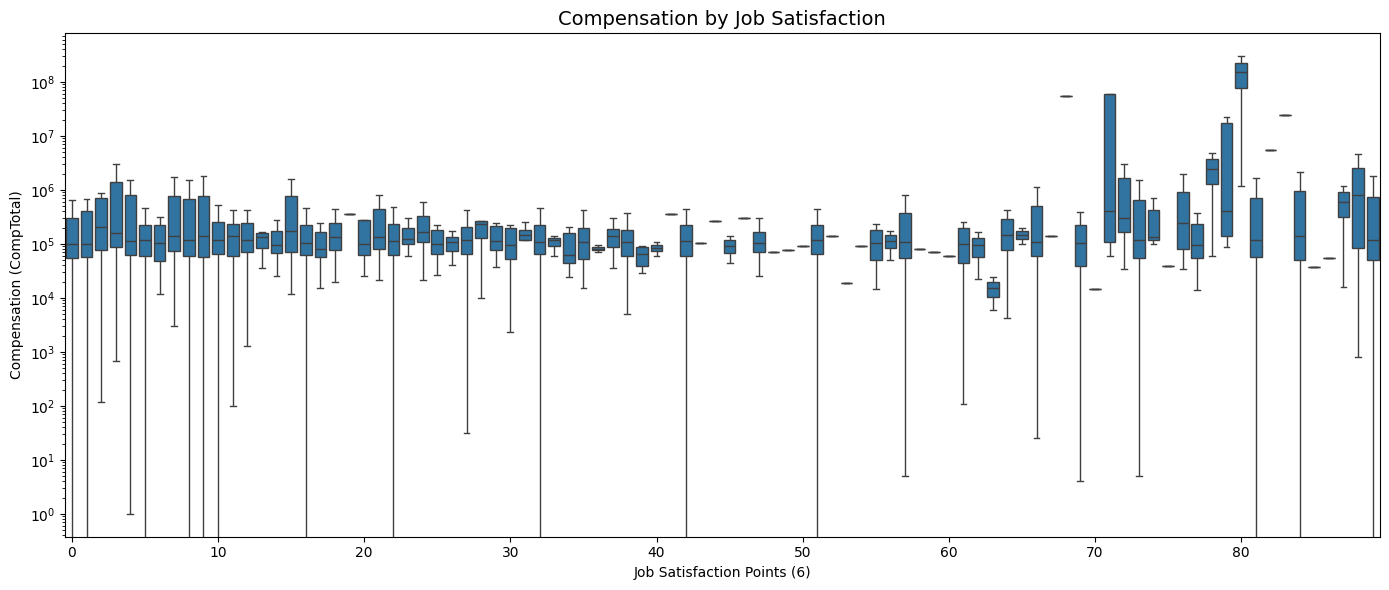

In [13]:
plt.figure(figsize=(14, 6))
ax = sns.boxplot(
    data=comp_sat6,
    x="JobSatPoints_6",
    y="CompTotal",
    showfliers=False
)
plt.yscale("log")
plt.xlabel("Job Satisfaction Points (6)")
plt.ylabel("Compensation (CompTotal)")
plt.title("Compensation by Job Satisfaction", fontsize=14)

# --- 4. Show only every 10th tick ---
xticks = ax.get_xticks()             # positions of all ticks
ax.set_xticks(xticks[::10])           # keep every 10th
ax.set_xticklabels(xticks[::10])      # set matching labels

plt.tight_layout()
plt.savefig("Lab 18 Plots/Step 2-2 CompTotal Grouped by JobSatPoints_6")
plt.show()

### Task 3: Visualizing the Composition of Data


**1. Box Plot of `ConvertedCompYearly` for the Top 5 Developer Types:**


Analyze compensation across the top 5 developer roles.


In [14]:
query = """
SELECT DevType, ConvertedCompYearly FROM main
"""

devtype_comp = pd.read_sql(sql=query, con=conn)
top_5_developers = list(devtype_comp["DevType"].value_counts().reset_index()["DevType"].head(5))
top_5 = devtype_comp[devtype_comp["DevType"].isin(top_5_developers)].dropna()

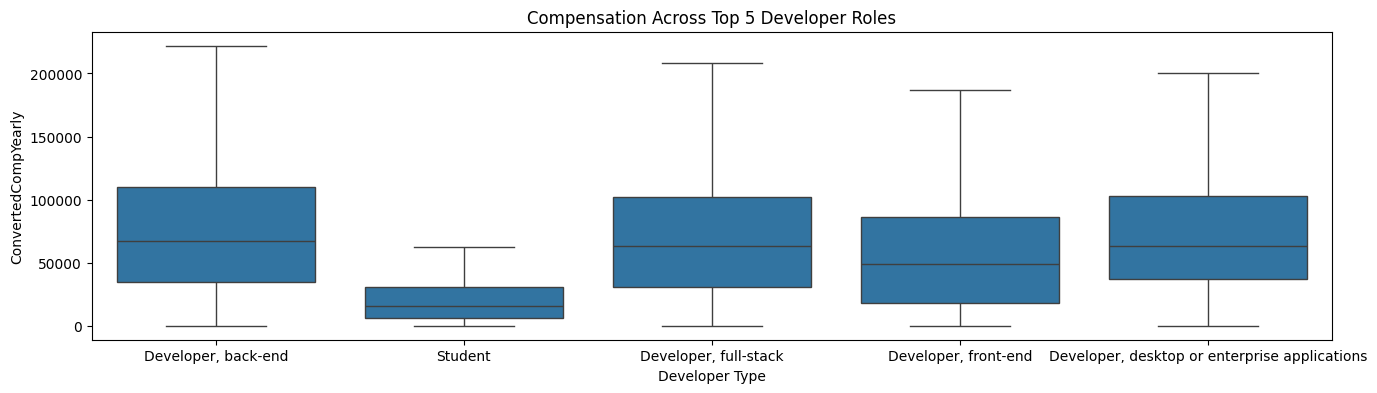

In [15]:
plt.figure(figsize=(16,4))
sns.boxplot(data=top_5, x="DevType", y="ConvertedCompYearly", showfliers=False)
plt.title("Compensation Across Top 5 Developer Roles")
plt.xlabel("Developer Type")
plt.savefig("Lab 18 Plots/Step 3-1 Compensation by Dev Type (No Outliers)")

**2. Box Plot of `CompTotal` for the Top 5 Countries:**


Analyze compensation across respondents from the top 5 countries.


In [16]:
query = """
SELECT Country, ConvertedCompYearly FROM main
"""

country_comp = pd.read_sql(sql=query, con=conn)
top_5_countries = list(country_comp["Country"].value_counts().reset_index()["Country"].head(5))
top_5 = country_comp[country_comp["Country"].isin(top_5_countries)].dropna()

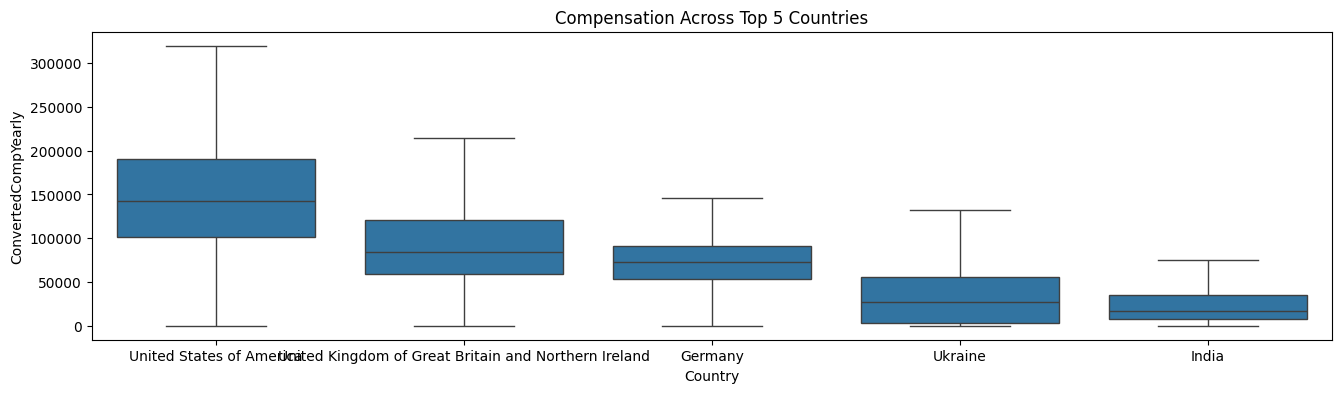

In [17]:
plt.figure(figsize=(16,4))
sns.boxplot(data=top_5, x="Country", y="ConvertedCompYearly", showfliers=False)
plt.title("Compensation Across Top 5 Countries")
plt.xlabel("Country")
plt.savefig("Lab 18 Plots/Step 3-2 Compensation by Country (No Outliers)")

### Task 4: Visualizing Comparison of Data


**1. Box Plot of CompTotal Across Employment Types:**


Analyze compensation for different employment types.


In [18]:
query = """
SELECT Employment, CompTotal FROM main
"""

employment_comp = pd.read_sql(sql=query, con=conn)
employment_comp["Employment"] = employment_comp["Employment"].str.split(';')
employment_comp_exploded = employment_comp.explode("Employment", ignore_index=True).dropna()
# employment_comp_exploded

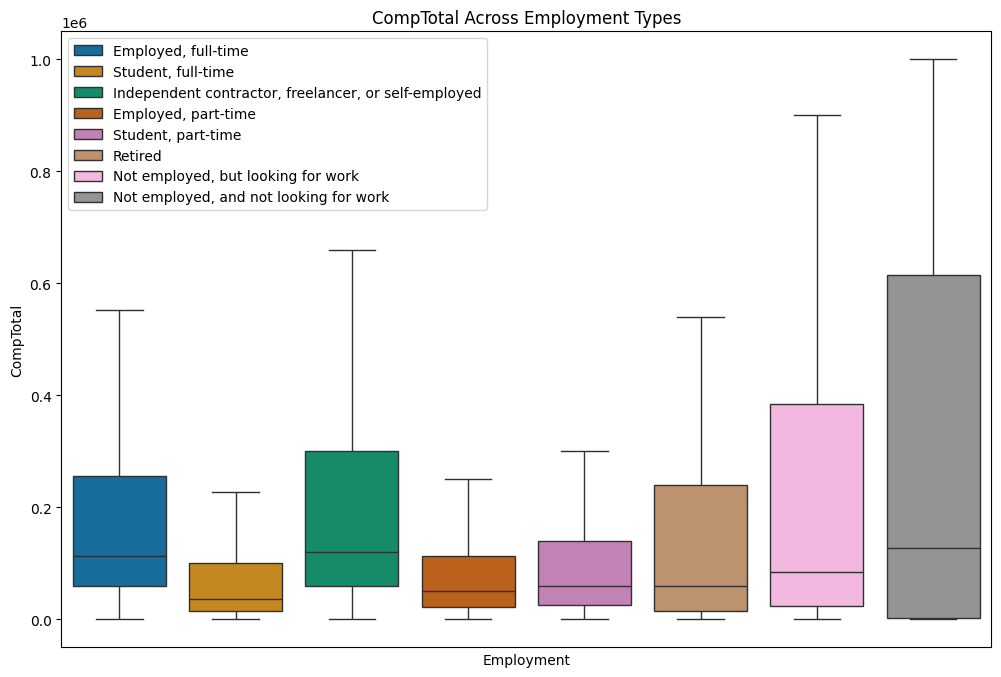

In [19]:
plt.figure(figsize=(12,8))
sns.boxplot(data=employment_comp_exploded, x="Employment", y="CompTotal", hue="Employment", palette="colorblind", legend=True, showfliers=False)
plt.title("CompTotal Across Employment Types")
plt.xlabel("Employment")
plt.xticks([])
plt.legend(loc='best')
plt.savefig("Lab 18 Plots/Step 4-1 CompTotal Across Employment Types (No Outliers)")

**2. Box Plot of `YearsCodePro` by Job Satisfaction (`JobSatPoints_6`):**


Examine the distribution of professional coding years by job satisfaction levels.


In [20]:
query = """
SELECT YearsCodePro, JobSat FROM main
"""

years_sat = pd.read_sql(sql=query, con=conn)
years_sat = years_sat.dropna(subset=["JobSat"])
years_sat["YearsCodePro"] = years_sat["YearsCodePro"].replace({"Less than 1 year":"0.5","More than 50 years":"51"})
years_sat["YearsCodePro"] = pd.to_numeric(years_sat["YearsCodePro"], errors='coerce')

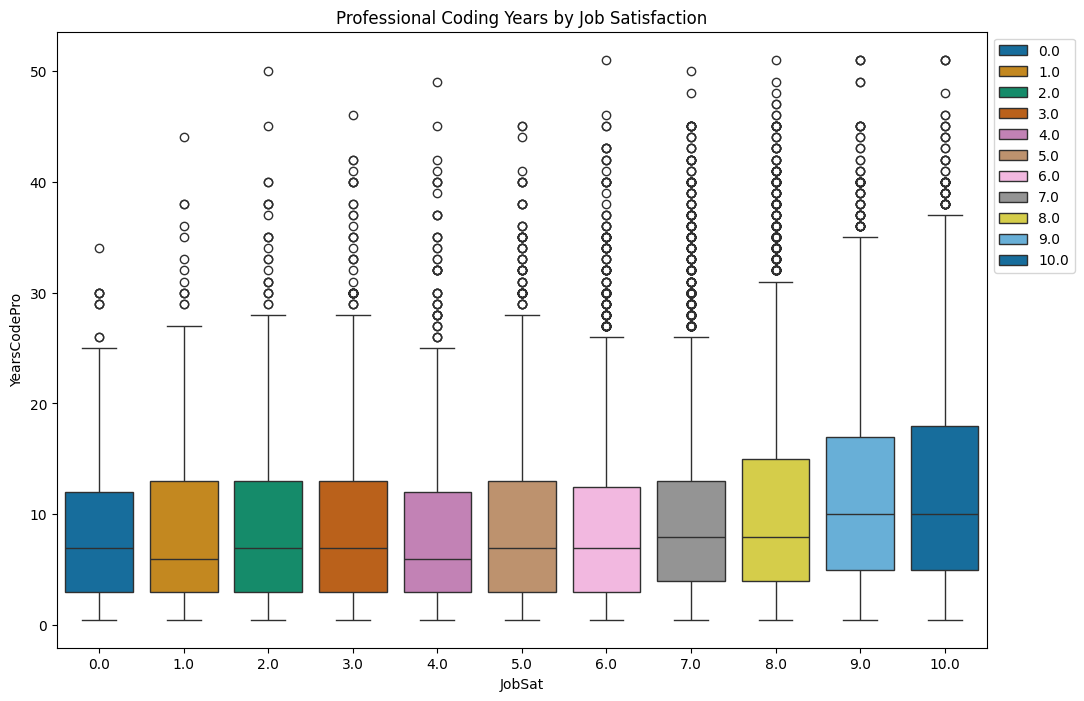

In [21]:
plt.figure(figsize=(12,8))
sns.boxplot(data=years_sat, x="JobSat", y="YearsCodePro", hue="JobSat", palette="colorblind", legend=True, showfliers=True)
plt.title("Professional Coding Years by Job Satisfaction")
plt.xlabel("JobSat")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("Lab 18 Plots/Step 4-2 Professional Coding Years by Job Satisfaction")

### Final Step: Close the Database Connection


After completing the lab, close the connection to the SQLite database:


In [22]:
conn.close()

## Summary


In this lab, you used box plots to visualize various aspects of the dataset, focusing on:

- Visualize distributions of compensation and age.

- Explore relationships between compensation, job satisfaction, and professional coding experience.

- Analyze data composition across developer roles and countries.

- Compare compensation across employment types and satisfaction levels.

Box plots provided clear insights into the spread, outliers, and central tendencies of various features in the dataset.


## Authors:
Ayushi Jain


### Other Contributors:
- Rav Ahuja
- Lakshmi Holla
- Malika


<!--## Change Log
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|               
|2024-10-07|1.2|Madhusudan Moole|Reviewed and updated lab|                                                                                      
|2024-10-06|1.0|Raghul Ramesh|Created lab|-->


Copyright © IBM Corporation. All rights reserved.
